# How does religious affiliation change with age?

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='white', font_scale=1.5)

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
gss = utils.ReadGss('gss_college_religion')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Resampling (bootstrapping to be more specific) to account for sampling weights.

In [3]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1946,26,0.8893,0,1,16,833,0
1,1972,0,0,1932,40,0.8893,0,1,14,96,0
2,1972,0,0,1946,26,0.8893,0,2,9,1032,0
3,1972,0,0,1927,45,0.8893,0,1,12,105,0
4,1972,0,0,1898,74,0.8893,0,1,9,405,0


Cleaning variables

In [4]:
sample.age.replace([98, 99], np.nan, inplace=True)
sum(sample.age.isnull())

181

In [5]:
sample.cohort.replace([9999], np.nan, inplace=True)
sum(sample.age.isnull())

181

In [6]:
sample.relig.replace([98, 99], np.nan, inplace=True)
sum(sample.age.isnull())

181

In [7]:
sample.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
sample.shape

(62006, 11)

In [8]:
utils.values(sample, 'age')

18.0     345
19.0    1152
20.0    1159
21.0    1255
22.0    1252
23.0    1422
24.0    1309
25.0    1308
26.0    1359
27.0    1357
28.0    1363
29.0    1251
30.0    1359
31.0    1213
32.0    1325
33.0    1264
34.0    1281
35.0    1262
36.0    1237
37.0    1238
38.0    1280
39.0    1147
40.0    1238
41.0    1166
42.0    1152
43.0    1243
44.0    1189
45.0    1140
46.0    1113
47.0    1154
        ... 
60.0     862
61.0     750
62.0     763
63.0     785
64.0     628
65.0     711
66.0     636
67.0     696
68.0     654
69.0     521
70.0     586
71.0     541
72.0     487
73.0     500
74.0     518
75.0     365
76.0     441
77.0     374
78.0     333
79.0     270
80.0     266
81.0     238
82.0     191
83.0     185
84.0     167
85.0     148
86.0     130
87.0     102
88.0      87
89.0     225
Name: age, dtype: int64

{'xscale': 'linear', 'yscale': 'linear'}

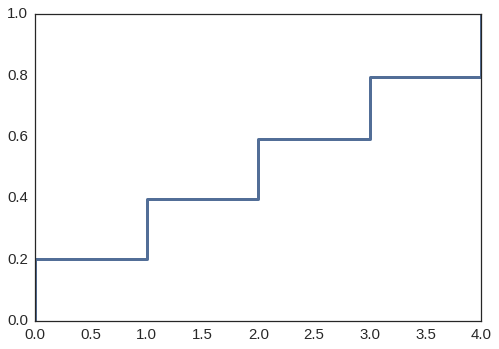

In [9]:
sample['age_group'] = utils.RoundIntoBins(sample, 'age', 5)
thinkplot.Cdf(thinkstats2.Cdf(sample.age - sample.age_group))

In [10]:
utils.values(sample, 'cohort')

1883.0      4
1884.0      1
1885.0      4
1886.0      7
1887.0     11
1888.0     11
1889.0     13
1890.0     15
1891.0     17
1892.0     23
1893.0     20
1894.0     50
1895.0     38
1896.0     44
1897.0     51
1898.0     81
1899.0    134
1900.0    123
1901.0    113
1902.0    125
1903.0    166
1904.0    132
1905.0    170
1906.0    175
1907.0    218
1908.0    188
1909.0    277
1910.0    234
1911.0    250
1912.0    301
         ... 
1969.0    775
1970.0    870
1971.0    674
1972.0    619
1973.0    618
1974.0    610
1975.0    589
1976.0    534
1977.0    549
1978.0    526
1979.0    562
1980.0    489
1981.0    444
1982.0    407
1983.0    361
1984.0    349
1985.0    361
1986.0    282
1987.0    286
1988.0    201
1989.0    228
1990.0    163
1991.0    184
1992.0    116
1993.0    115
1994.0    124
1995.0     90
1996.0     52
1997.0     39
1998.0      9
Name: cohort, dtype: int64

{'xscale': 'linear', 'yscale': 'linear'}

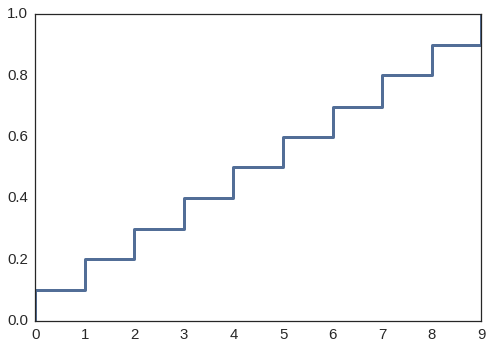

In [11]:
sample['decade'] = utils.RoundIntoBins(sample, 'cohort', 10)
thinkplot.Cdf(thinkstats2.Cdf(sample.cohort - sample.decade))

Religion code 4 represents people who report no religious affiliation.

In [12]:
utils.values(sample, 'relig')

1.0     35207
2.0     15796
3.0      1195
4.0      7205
5.0      1109
6.0       183
7.0       110
8.0        35
9.0       166
10.0      123
11.0      751
12.0       33
13.0       93
Name: relig, dtype: int64

In [13]:
sample['none'] = sample.relig ==4
sample.none.mean()

0.11619843240976679

Group by year and college status.

In [14]:
grouped = sample.groupby(['decade', 'age_group'])

Count the number of observations in each decade/age group.

In [15]:
counts = grouped.none.count().unstack()
counts

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
decade,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,47.0
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,201.0,117.0,99.0
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,374.0,508.0,344.0,238.0,166.0
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,617.0,712.0,655.0,662.0,405.0,254.0,194.0
1920.0,NaN,NaN,NaN,NaN,NaN,85.0,768.0,1021.0,998.0,824.0,763.0,600.0,404.0,287.0,170.0
1930.0,NaN,NaN,NaN,80.0,623.0,948.0,934.0,935.0,825.0,746.0,630.0,491.0,389.0,147.0,16.0
1940.0,NaN,109.0,825.0,1234.0,1178.0,1309.0,1366.0,1186.0,1051.0,855.0,710.0,315.0,40.0,NaN,NaN
1950.0,328.0,1515.0,1587.0,1558.0,1693.0,1642.0,1604.0,1346.0,1106.0,594.0,86.0,NaN,NaN,NaN,NaN
1960.0,340.0,1574.0,1579.0,1612.0,1495.0,1434.0,1024.0,689.0,98.0,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
percent_none = grouped.none.mean().unstack()
percent_none

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
decade,,,,,,,,,,,,,,,
1880.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.000000
1890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035714,0.044776,0.008547,0.000000
1900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.024064,0.045276,0.029070,0.016807,0.018072
1910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063291,0.029173,0.042135,0.038168,0.054381,0.041975,0.039370,0.051546
1920.0,NaN,NaN,NaN,NaN,NaN,0.035294,0.042969,0.029383,0.035070,0.033981,0.040629,0.030000,0.086634,0.066202,0.058824
1930.0,NaN,NaN,NaN,0.075000,0.054575,0.053797,0.061028,0.031016,0.048485,0.042895,0.065079,0.065173,0.059126,0.074830,0.187500
1940.0,NaN,0.165138,0.104242,0.079417,0.078947,0.075630,0.081259,0.084317,0.094196,0.098246,0.123944,0.123810,0.150000,NaN,NaN
1950.0,0.143293,0.114191,0.112791,0.080231,0.102185,0.125457,0.135287,0.121842,0.162749,0.183502,0.127907,NaN,NaN,NaN,NaN
1960.0,0.150000,0.109911,0.127929,0.151365,0.141137,0.135983,0.166016,0.200290,0.091837,NaN,NaN,NaN,NaN,NaN,NaN


Drop cells where we have fewer than 50 observations.

In [17]:
percent_none[counts < 50] = np.nan

In [18]:
decades = np.linspace(1930, 1980, 6, endpoint=True)
percent_none.loc[decades]

age_group,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0,85.0
decade,,,,,,,,,,,,,,,
1930.0,NaN,NaN,NaN,0.075000,0.054575,0.053797,0.061028,0.031016,0.048485,0.042895,0.065079,0.065173,0.059126,0.07483,NaN
1940.0,NaN,0.165138,0.104242,0.079417,0.078947,0.075630,0.081259,0.084317,0.094196,0.098246,0.123944,0.123810,NaN,NaN,NaN
1950.0,0.143293,0.114191,0.112791,0.080231,0.102185,0.125457,0.135287,0.121842,0.162749,0.183502,0.127907,NaN,NaN,NaN,NaN
1960.0,0.150000,0.109911,0.127929,0.151365,0.141137,0.135983,0.166016,0.200290,0.091837,NaN,NaN,NaN,NaN,NaN,NaN
1970.0,0.134276,0.176512,0.203997,0.210078,0.217514,0.294737,0.082192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980.0,0.206061,0.292256,0.272810,0.306886,0.283186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


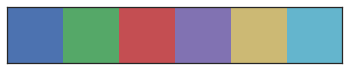

In [19]:
colors = sns.color_palette()
sns.palplot(colors)

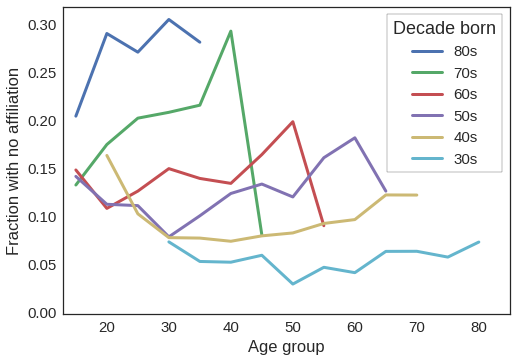

In [20]:
options = dict(alpha=1)

thinkplot.preplot(6)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.plot(percent_none.loc[1950], label='50s', color=colors[3], **options)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)

xlabel = 'Age group'
ylabel = 'Fraction with no affiliation'
axis = [13, 85, 0, 0.32]

thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, legend=True)
plt.gca().get_legend().set(title='Decade born');

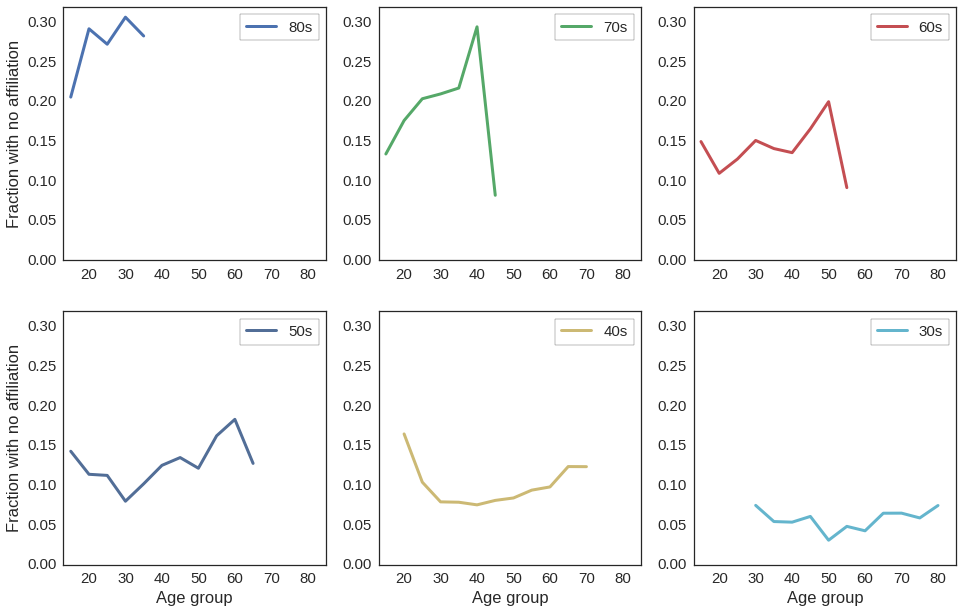

In [21]:
thinkplot.preplot(num=6, rows=2, cols=3)
thinkplot.subplot(1)
thinkplot.plot(percent_none.loc[1980], label='80s', color=colors[0], **options)
thinkplot.config(ylabel=ylabel, axis=axis)

thinkplot.subplot(2)
thinkplot.plot(percent_none.loc[1970], label='70s', color=colors[1], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(3)
thinkplot.plot(percent_none.loc[1960], label='60s', color=colors[2], **options)
thinkplot.config(axis=axis)

thinkplot.subplot(4)
thinkplot.plot(percent_none.loc[1950], label='50s')
thinkplot.config(xlabel=xlabel, ylabel=ylabel, axis=axis, color=colors[3], **options)

thinkplot.subplot(5)
thinkplot.plot(percent_none.loc[1940], label='40s', color=colors[4], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

thinkplot.subplot(6)
thinkplot.plot(percent_none.loc[1930], label='30s', color=colors[5], **options)
thinkplot.config(xlabel=xlabel, axis=axis)

In [22]:
sample['age_group10'] = utils.RoundIntoBins(sample, 'age', 10)

In [23]:
sample['year4'] = utils.RoundIntoBins(sample, 'year', 4, low=2)

In [24]:
grouped = sample.groupby(['age_group10', 'year4'])

In [25]:
counts = grouped.none.count().unstack()
counts

year4,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014
age_group10,,,,,,,,,,,,
10.0,93,204,77,160,185,73,115,122,116,146,104,102
20.0,714,1429,756,1620,1418,964,1164,1051,1073,1182,730,934
30.0,511,1104,637,1332,1365,1055,1351,1247,1082,1210,721,991
40.0,624,990,444,1002,1157,891,1255,1282,1168,1381,716,847
50.0,556,1027,474,1006,753,527,865,806,940,1193,747,1057
60.0,338,673,334,709,721,474,607,490,580,713,556,811
70.0,221,431,203,435,497,365,364,410,372,410,287,420
80.0,30,109,59,155,174,128,152,184,188,232,131,197


In [26]:
percent_none = grouped.none.mean().unstack()
percent_none[counts < 50] = np.nan
percent_none*=100
percent_none

year4,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014
age_group10,,,,,,,,,,,,
10.0,11.827957,16.176471,10.389610,15.625000,13.513514,9.589041,19.130435,19.672131,18.103448,19.178082,24.038462,24.509804
20.0,12.324930,11.196641,11.111111,11.358025,9.943583,9.336100,17.353952,23.882017,24.044734,24.873096,28.630137,31.477516
30.0,4.696673,7.789855,8.948195,6.531532,9.597070,10.710900,11.547002,14.915798,16.173752,19.834711,22.607490,30.776993
40.0,2.724359,6.565657,6.531532,4.890220,7.000864,7.744108,11.394422,14.118565,13.356164,14.844316,18.575419,22.195986
50.0,4.496403,2.434275,2.320675,3.081511,4.116866,4.554080,7.052023,9.553350,10.531915,11.986588,17.536814,17.880795
60.0,2.662722,3.120357,3.892216,3.808181,3.467406,3.586498,4.777595,5.306122,7.068966,9.256662,13.848921,16.892725
70.0,2.714932,5.336427,2.955665,3.218391,3.420523,7.397260,4.670330,4.390244,6.451613,8.292683,6.968641,10.476190
80.0,NaN,0.000000,0.000000,1.935484,1.724138,2.343750,5.921053,2.717391,6.382979,4.310345,6.106870,8.629442


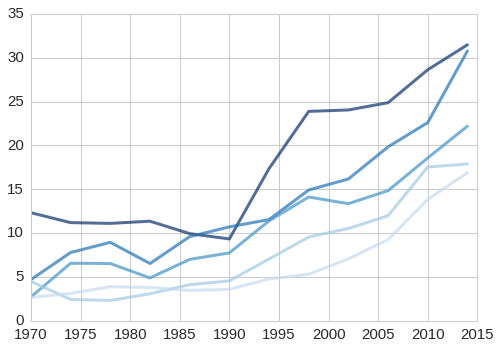

In [27]:
sns.set(style='whitegrid', font_scale=1.5)

rows = percent_none.loc[20:65]
for age_group, row in rows.iterrows():
    thinkplot.plot(row)

In [28]:
row

year4
1970     2.662722
1974     3.120357
1978     3.892216
1982     3.808181
1986     3.467406
1990     3.586498
1994     4.777595
1998     5.306122
2002     7.068966
2006     9.256662
2010    13.848921
2014    16.892725
Name: 60.0, dtype: float64

In [29]:
def FitRow(row, formula='y ~ time + time2'):
    """Fits a model to a Series.
    
    row: Series
    formula: Patsy string
    
    returns: RegressionResults
    """

    time = row.index
    time -= min(time)
    time2 = time**2
    
    df = pd.DataFrame(dict(time=time, time2=time2, y=row))
    results = smf.ols(formula, data=df).fit()
    return results

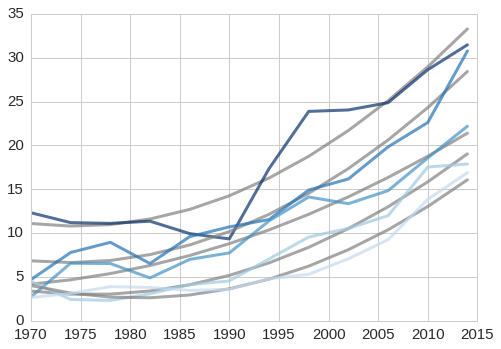

In [30]:
for age_group, row in rows.iterrows():
    results = FitRow(row)
    thinkplot.plot(results.fittedvalues, color='gray')
    thinkplot.plot(row)

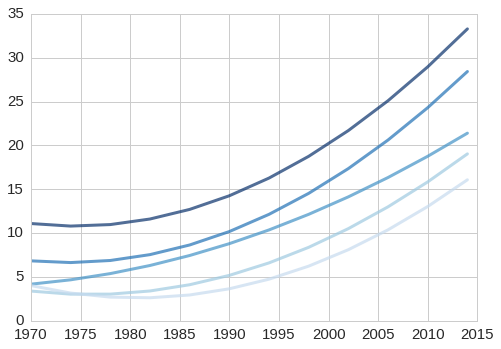

In [31]:
for age_group, row in rows.iterrows():
    results = FitRow(row)
    ys = results.fittedvalues
    thinkplot.plot(ys)

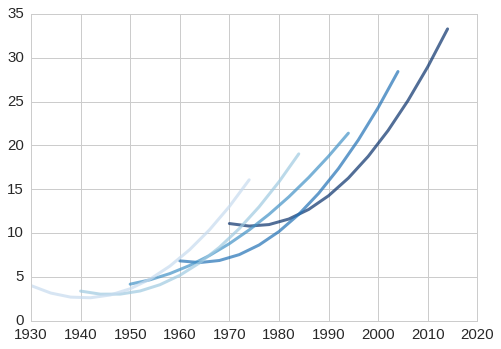

In [32]:
shift = 0
for age_group, row in rows.iterrows():
    results = FitRow(row)
    ys = results.fittedvalues
    ys.index -= shift
    shift += 10
    thinkplot.plot(ys)

In [33]:
heri = pd.read_csv('heri17.csv', skiprows=2, index_col='year')
heri[heri.columns] /= 10
heri.tail()

,noneall,fatherall,motherall,attendedall,nonemen,fathermen,mothermen,attendedmen,nonewomen,fatherwomen,motherwomen,attendedwomen,bornagain,evangelical
year,,,,,,,,,,,,,,
2012,23.8,16.8,11.8,73.2,26.3,16.4,11.9,70.7,21.7,17.1,11.7,75.4,20.2,8.5
2013,24.6,17.1,12.1,72.7,26.9,16.2,12.0,70.3,22.6,17.9,12.1,74.8,NaN,NaN
2014,27.5,19.0,13.8,70.7,30.0,18.4,13.7,68.3,25.4,19.5,13.9,72.7,NaN,NaN
2015,29.6,16.6,16.4,69.5,31.8,NaN,NaN,67.8,27.7,NaN,NaN,70.8,NaN,NaN
2016,30.9,NaN,NaN,68.9,33.1,NaN,NaN,67.1,29.1,NaN,NaN,70.4,NaN,NaN


In [34]:
heri['time'] = heri.index - 1966
heri['time2'] = heri.time**2

20.0
30.0
40.0
50.0
60.0


thinkplot.py:118: UserWarning: Ran out of colors.  Starting over.
  warnings.warn('Ran out of colors.  Starting over.')


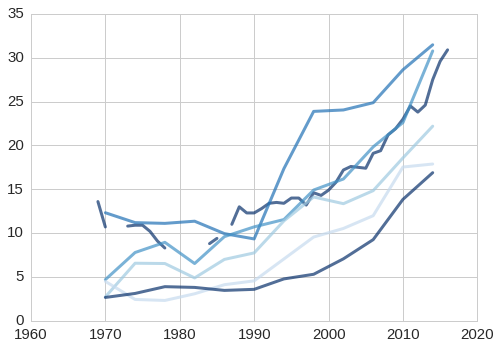

In [35]:
thinkplot.plot(heri.noneall)

for age_group, row in rows.iterrows():
    print(age_group)
    #results = FitRow(row)
    #thinkplot.plot(results.fittedvalues, color='gray')
    thinkplot.plot(row)

In [36]:
sample['none'] = (sample.relig==4)
sample['cath'] = (sample.relig==2)
sample['prot'] = (sample.relig==1)

In [37]:
grouped = sample.groupby(['year'])

In [38]:
percent_none = grouped.none.mean() * 100
percent_prot = grouped.prot.mean() * 100
percent_cath = grouped.cath.mean() * 100

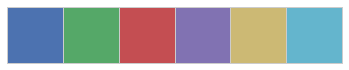

In [43]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(colors)

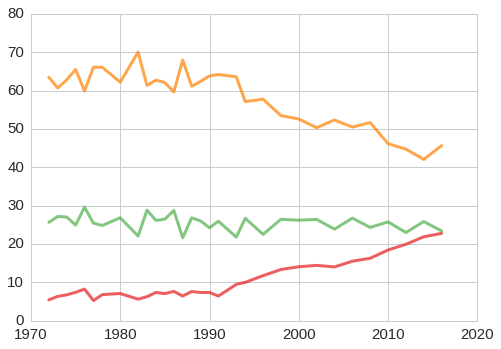

In [44]:
thinkplot.plot(percent_prot, color=ORANGE, label='Protestant')
thinkplot.plot(percent_cath, color=GREEN, label='Catholic')
thinkplot.plot(percent_none, color=RED, label='None')

In [45]:
def percent_relig(df):
    return df[['prot', 'cath', 'none']].mean()

In [46]:
percent_relig(sample[sample.year==2016])

prot    0.456851
cath    0.234237
none    0.227897
dtype: float64

In [47]:
columns = ['age', 'year', 'prot', 'cath', 'none']
recent = sample.loc[sample.year>=2010, columns].copy()
recent.shape

(9351, 5)

In [48]:
percent_relig(recent)

prot    0.446155
cath    0.245107
none    0.210138
dtype: float64

In [49]:
recent.year.mean()

2013.318789434285

{'xscale': 'linear', 'yscale': 'linear'}

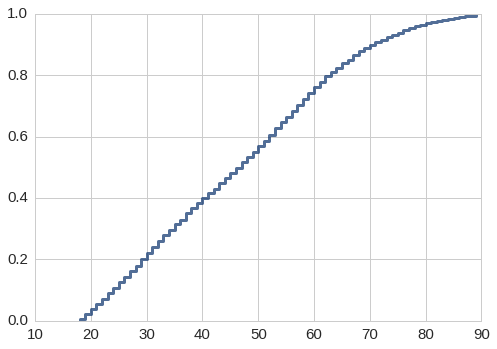

In [50]:
thinkplot.Cdf(thinkstats2.Cdf(recent.age))

In [51]:
def advance(df):
    new = df.copy()
    new.year += 1
    new.age += 1
    
    
    return new

In [52]:
df = recent
pr = percent_relig(recent)
series = pd.DataFrame(columns=pr.index)

for _ in range(10):
    df = advance(df)
    year = df.year.mean()
    series.loc[year] = percent_relig(df)

In [53]:
series

,prot,cath,none
2014.318789,0.446155,0.245107,0.210138
2015.318789,0.446155,0.245107,0.210138
2016.318789,0.446155,0.245107,0.210138
2017.318789,0.446155,0.245107,0.210138
2018.318789,0.446155,0.245107,0.210138
2019.318789,0.446155,0.245107,0.210138
2020.318789,0.446155,0.245107,0.210138
2021.318789,0.446155,0.245107,0.210138
2022.318789,0.446155,0.245107,0.210138
2023.318789,0.446155,0.245107,0.210138


In [54]:
# https://www.cdc.gov/nchs/data/dvs/mortfinal2007_worktable23r.pdf

ts = np.array([24, 34, 44, 54, 64, 74, 84])
rs = np.array([79.9, 104.9, 184.4, 420.9, 877.7, 2011.3, 5011.6, 12946.5]) / 100000

In [55]:
indices = np.searchsorted(ts, recent.age)
rates = rs[indices]
rates.mean()

0.009717219869532669

In [56]:
dead = np.random.random(len(rates)) < rates
dead

array([False, False, False, ..., False, False, False], dtype=bool)

In [57]:
sum(dead)

109

In [58]:
def choose_dead(df):
    # compute death rates in each age group
    # data from 2007
    # https://www.cdc.gov/nchs/data/dvs/mortfinal2007_worktable23r.pdf
    ts = np.array([24, 34, 44, 54, 64, 74, 84])
    rs = np.array([79.9, 104.9, 184.4, 420.9, 877.7, 2011.3, 5011.6, 12946.5]) / 100000
    
    # look up the death rate for each respondent
    indices = np.searchsorted(ts, df.age)
    rates = rs[indices]
    
    # choose who dies
    dead = np.random.random(len(rates)) < rates
    return dead

In [59]:
choose_dead(recent).sum()

95

In [64]:
dead_age = recent[dead].age

In [68]:
mean_age = recent.age.mean()
mean_age

46.962356967169285

In [70]:
new_age = 2*mean_age - dead_age
new_age

53098    30.924714
53148    43.924714
53221    43.924714
53263    26.924714
53338     4.924714
53407    19.924714
53557    35.924714
53591     5.924714
53633    25.924714
53789    17.924714
53881    21.924714
53904     4.924714
53936    23.924714
54022    25.924714
54049    30.924714
54116     4.924714
54404    26.924714
54411     4.924714
54455    49.924714
54667    37.924714
54769     8.924714
54970     8.924714
55002     8.924714
55008     4.924714
55035    29.924714
55046    30.924714
55096    12.924714
55196    25.924714
55329    32.924714
55511    31.924714
           ...    
60034    13.924714
60113    47.924714
60126    10.924714
60166     4.924714
60257     4.924714
60316    26.924714
60349    25.924714
60451    25.924714
60634    28.924714
60711    16.924714
60770    15.924714
60782    28.924714
61035    27.924714
61081     7.924714
61311    16.924714
61431    62.924714
61473    15.924714
61519    13.924714
61556    12.924714
61634    25.924714
61668    10.924714
61927    37.

In [71]:
updated = recent.copy()
updated.loc[dead, 'age'] = new_age

In [72]:
updated.age.mean()

46.393839569975825